In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import timeit

In [5]:
# Надстройка для изменения размера графика
sns.set(rc={'figure.figsize': (8,5)})

In [6]:
events_data = pd.read_csv('data/event_data_train.zip', sep=',', compression ='zip')
display(events_data.head())
display(events_data.shape)

submissions_data = pd.read_csv('data/submissions_data_train.zip', sep=',', compression ='zip')
display(submissions_data.head())
display(submissions_data.shape)

step_id   timestamp      action  user_id
0    32815  1434340848      viewed    17632
1    32815  1434340848      passed    17632
2    32815  1434340848  discovered    17632
3    32811  1434340895  discovered    17632
4    32811  1434340895      viewed    17632

(3480703, 4)

step_id   timestamp submission_status  user_id
0    31971  1434349275           correct    15853
1    31972  1434348300           correct    15853
2    31972  1478852149             wrong    15853
3    31972  1478852164           correct    15853
4    31976  1434348123             wrong    15853

(509104, 4)

Описание данных:

**events_train.csv** - данные о действиях, которые совершают студенты со стэпами

| Название | Описание |
| --- | ---|
| step_id | id стэпа |
| user_id | анонимизированный id юзера |
| timestamp | время наступления события в формате unix date |
| action | событие, возможные значения: <br>
|  | *discovered* - пользователь перешел на стэп <br>*viewed* - просмотр шага, <br>*started_attempt* - начало попытки решить шаг,<br>   ранее нужно было явно нажать на кнопку начать решение,<br> перед тем как приступить к решению практического шага <br>*passed* - удачное решение практического шага

**submissions_train.csv** - данные о времени и статусах сабмитов к практическим заданиям

| Название | Описание |
| --- | ---|
|step_id | id стэпа |
|timestamp | время отправки решения в формате unix date |
|submission_status | статус решения |
|user_id | анонимизированный id юзера |

В курсе 198 шагов. Каждый  завершается passed. Данные по шагам в файле events_train. Некоторые из этих шагов (76 штук) содержат задачи, которые нужно решить. Данные по решению задач - во втором файле (submissions_train).

Все 76 step_id, которые есть в submissions_data, также есть в events_train.

Переведём дату из формата *timestamp* (секунды) в формат *datetime* . Создадим признаки date и day

In [7]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
display(submissions_data.head())

events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date
display(events_data.head())

step_id   timestamp submission_status  user_id                date  \
0    31971  1434349275           correct    15853 2015-06-15 06:21:15   
1    31972  1434348300           correct    15853 2015-06-15 06:05:00   
2    31972  1478852149             wrong    15853 2016-11-11 08:15:49   
3    31972  1478852164           correct    15853 2016-11-11 08:16:04   
4    31976  1434348123             wrong    15853 2015-06-15 06:02:03   

          day  
0  2015-06-15  
1  2015-06-15  
2  2016-11-11  
3  2016-11-11  
4  2015-06-15

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

Найдём количество сабмитов: правильных и неправильных. Для этого построим таблицу pivot table

In [8]:
users_scores = submissions_data.pivot_table(
    index='user_id', 
    columns='submission_status', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0).reset_index()
users_scores

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1
...                    ...      ...    ...
9935                 26787        3      0
9936                 26790        1      0
9937                 26794       33      9
9938                 26797        2      0
9939                 26798        2      1

[9940 rows x 3 columns]

Мы знаем количество дней обучения, количество пройденных степов и сабмитов. Проверим различаются ли эти показатели в группе пользователей завершивших курс и группе бросивших курс. 

Поскольку данные не содержат четкого определения каких пользователей мы считаем бросившими курс, то его необходимо установить посредством статистического анализа промежутков времени между сабмитами.

Примечательно, что у каждого пользователя могут быть несколько активностей в данный день. Будем считать пользователя активным, если он зашел на платформу хотя бы один раз в день

In [9]:
# Удаляем дубликаты только по айди и дням
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()

user_id         day   timestamp
0     17632  2015-06-15  1434340848
36    12494  2015-06-15  1434341931
59      442  2015-06-15  1434342029
62    22254  2015-06-15  1434342042
94     6646  2015-06-15  1434342230

In [10]:
# Для каждого пользователя находим уникальные таймстемпы
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']). \
groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [11]:
# Для каждого пользователя находим разницу по времени между степами
# функция np.diff вычисляет разницу между соседними значениями в списке
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).head()
display(gap_data)

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [12]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [13]:
# сохраним разницу в виде Series
gap_data = pd.DataFrame({'Gap': np.hstack(gap_data)})
display(gap_data)

Gap
0       4843602
1       6899249
2        182484
3         93710
4       2768870
...         ...
97867  14347289
97868    505061
97869     98252
97870     57019
97871   1567990

[97872 rows x 1 columns]

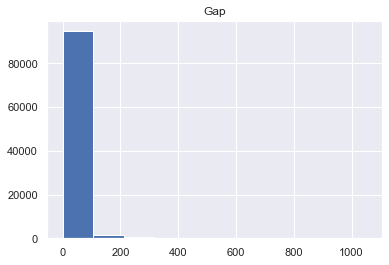

In [14]:
# разница в днях = час * минуты * секунды
gap_data = gap_data / (24 * 60 * 60)
gap_data.hist();

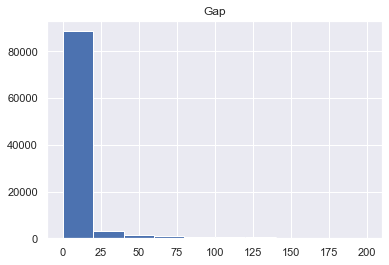

In [15]:
fig_2 = px.histogram(gap_data[gap_data < 200], 
    nbins=10,
    opacity=0.5, # непрозрачность 
    marginal='box')

fig_2.update_layout(
    title=dict(text='Рис.2 - Перерывы между степами <br> в месяцах', x=.5, xanchor='center'),
    xaxis_title_text = 'Длительность перерыва, мес.',
    yaxis_title_text = 'Пользователи, чел.',
    width=600, height=400,
    template="simple_white"
)
fig_2.show();
gap_data[gap_data < 200].hist();

In [16]:
# Какой перерыв у 90% пользователей
print(f"перерыв у 90% пользователей составляет: {round(gap_data.quantile(.9)[0],2)} дней")
print(f"перерыв у 95% пользователей составляет: {round(gap_data.quantile(.95)[0],2)} дней")

перерыв у 90% пользователей составляет: 18.33 дней
перерыв у 95% пользователей составляет: 59.76 дней


In [17]:
#1.11 Найти id Анатолия карпова
#Первый пользователь, прошедший последний стэп:
display(events_data[(events_data.action == 'passed') & (events_data.step_id == events_data.step_id.max())].head())

step_id   timestamp  action  user_id                date         day
1780990   158433  1485263664  passed     1046 2017-01-24 13:14:24  2017-01-24
1781275   158433  1485271669  passed     3931 2017-01-24 15:27:49  2017-01-24
1781402   158433  1485276014  passed    14985 2017-01-24 16:40:14  2017-01-24
1782093   158433  1485288441  passed    10626 2017-01-24 20:07:21  2017-01-24
1782261   158433  1485292242  passed     3876 2017-01-24 21:10:42  2017-01-24

Определим пользователя, который забросил курс:
- возьмём средний перерыв в 30 дней, больше котрого будем считать отсутствие значимым;
- такой пользователь не получил сертификат об окончании

In [18]:
# вычислим максимальное время (timestamp) появления на курсе для каждого пользователя
events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'max'}).head()

user_id   timestamp
0        1  1472827464
1        2  1519226966
2        3  1444581588
3        5  1499859939
4        7  1521634660

In [19]:
# перенесём данные в датасет, в которой прищнак timestamp переименуем в 'last_timestamp' 
users_data = events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})
display(users_data.head())

user_id  last_timestamp
0        1      1472827464
1        2      1519226966
2        3      1444581588
3        5      1499859939
4        7      1521634660

In [20]:
# Вычислим сколько времени прошло до максимальной даты (это текущий день)
display(events_data.tail(1))

#timestamp = 1526772811 - это текущий день
now = 1526772811

# вычислим порог 30 дней в секундах
drop_out_treshold = 30 * 24 * 60 * 60
print(f"drop_out_treshold = {drop_out_treshold} sec")

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold
display(users_data.head())

step_id   timestamp  action  user_id                date         day
3480702    33892  1526772811  viewed    18526 2018-05-19 23:33:31  2018-05-19

drop_out_treshold = 2592000 sec


user_id  last_timestamp  is_gone_user
0        1      1472827464          True
1        2      1519226966          True
2        3      1444581588          True
3        5      1499859939          True
4        7      1521634660          True

Мы получили признак 'user_is_gone', выражающий уход с курса. Добавим к нему остальные признаки пользователей и построим аггрегированную таблицу:
- является ли он ушедшим;
- когда последний раз он был онлайн;
- сколько у него баллов;
- сколько попыток он сделал.

In [24]:
display(users_scores.head())

#выполним слияние
users_data = users_data.merge(users_scores, how='outer')
display(users_data.head())

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1

user_id  last_timestamp  is_gone_user  correct  wrong
0        1      1472827464          True      NaN    NaN
1        2      1519226966          True      2.0    0.0
2        3      1444581588          True     29.0   23.0
3        5      1499859939          True      2.0    2.0
4        7      1521634660          True      NaN    NaN

In [25]:
# заполним пропущенные данные нулями
users_data.fillna(0).head()

user_id  last_timestamp  is_gone_user  correct  wrong
0        1      1472827464          True      0.0    0.0
1        2      1519226966          True      2.0    0.0
2        3      1444581588          True     29.0   23.0
3        5      1499859939          True      2.0    2.0
4        7      1521634660          True      0.0    0.0

In [26]:
# остальные события
users_events_data = events_data.pivot_table(
    index='user_id', 
    columns='action', 
    values='step_id', 
    aggfunc='count', 
    fill_value=0).reset_index()

users_events_data.head()

action  user_id  discovered  passed  started_attempt  viewed
0             1           1       0                0       1
1             2           9       9                2      10
2             3          91      87               30     192
3             5          11      11                4      12
4             7           1       1                0       1

In [27]:
#добавим остальные события к датафрейму users_data 
users_data = users_data.merge(users_events_data, how='outer')
display(users_data.head())

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed  \
0        1      1472827464          True      NaN    NaN           1       0   
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      NaN    NaN           1       1   

   started_attempt  viewed  
0                0       1  
1                2      10  
2               30     192  
3                4      12  
4                0       1

In [31]:
# найдём сколько уникальных дней пользователь был на курсе
users_days = events_data.groupby('user_id').day.nunique()
display(users_days.head(2))

# преобразуем данные из формата Series в формат DataFrame
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
display(users_days.head(2))

# добавим эту информацию к таблице остальных событий
users_data = users_data.merge(users_days, how='outer')
display(users_data.head())

user_id
1    1
2    2
Name: day, dtype: int64

user_id  day
0        1    1
1        2    2

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed  \
0        1      1472827464          True      NaN    NaN           1       0   
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      NaN    NaN           1       1   

   started_attempt  viewed  day  
0                0       1    1  
1                2      10    2  
2               30     192    7  
3                4      12    2  
4                0       1    1

In [32]:
# ПРоверяем сколько уникальных пользователей в нашей таблице
display(users_data.user_id.nunique())
display(events_data.user_id.nunique())

19234

19234

Сколько человек прошло курс?

In [33]:
# отделим закончивших курс, т.е. тех, которые прошли 170 шагов
users_data['passed_course'] = users_data.passed > 170
users_data.groupby('passed_course').count()

user_id  last_timestamp  is_gone_user  correct  wrong  \
passed_course                                                          
False            17809           17809         17809     8515   8515   
True              1425            1425          1425     1425   1425   

               discovered  passed  started_attempt  viewed    day  
passed_course                                                      
False               17809   17809            17809   17809  17809  
True                 1425    1425             1425    1425   1425

In [41]:
# 100*1425/17809 - доля прошедших курс
print(f"Доля закончивших курс: \n{round(users_data['passed_course'].value_counts(normalize=True)*100)} %")# второй способ

Доля закончивших курс: 
False    93.0
True      7.0
Name: passed_course, dtype: float64 %
